# HW 1 Submarine Tracking
#### Hunter Lybbert
#### Student ID 2426454
#### 01-16-25

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

import plotly
import plotly.graph_objs as go
from IPython.display import clear_output

plt.rcParams.update({'font.size': 16})

# %matplotlib notebook

In [2]:
use_submarine_marker = False
sub_marker = 'o'
marker_size = 2
ani_marker_size = 4

import matplotlib as mpl
from svgpath2mpl import parse_path
from svgpathtools import svg2paths

if use_submarine_marker:
    sub_marker_path, attributes = svg2paths('marker_svg/submarine1.svg')

    sub_marker = parse_path(attributes[0]['d'])

    sub_marker.vertices -= sub_marker.vertices.mean(axis=0)
    sub_marker = sub_marker.transformed(mpl.transforms.Affine2D().rotate_deg(-115))
    sub_marker = sub_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    marker_size = 8
    ani_marker_size = 25

In [3]:
data_path = 'data/subdata.npy'

subdata = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)

In [4]:
# plot the data in time

# NOTE: L we defined in class is 2Lh here, i.e. the domain here is [-Lh,Lh].
Lh = 10; # length of spatial domain (cube of side L = 2*10). 
N_grid = 64; # number of grid points/Fourier modes in each direction
xx = np.linspace(-Lh, Lh, N_grid+1) #spatial grid in x dir
x = xx[0:N_grid]
y = x # same grid in y,z direction
z = x

K_grid = (2*np.pi/(2*Lh))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid) # frequency grid for one coordinate

xv, yv, zv = np.meshgrid( x, y, z) # generate 3D meshgrid for plotting

# plot iso surfaces for every third measurement

# for j in range(0,49,3):
#   signal = np.reshape(subdata[:, j], (N_grid, N_grid, N_grid))
#   normal_sig_abs = np.abs(signal)/np.abs(signal).max()

#   # generate data for isosurface of the 3D data 
#   fig_data = go.Isosurface( x = xv.flatten(), y = yv.flatten(), z = zv.flatten(),
#                             value = normal_sig_abs.flatten(), isomin=0.6, isomax=1)

#   # generate plots
#   clear_output(wait=True) # need this to discard previous figs
#   fig = go.Figure( data = fig_data )
#   fig.show()


In [5]:
subdata_reshaped = subdata.reshape(64,64,64,49)

fhat_subdata = np.fft.fftn(
    subdata_reshaped,
    axes=(0,1,2),
)
fhat_shifted_subdata = np.fft.fftshift(fhat_subdata, axes=(0,1,2))
fhat_shifted_mean_subdata = fhat_shifted_subdata.mean(axis=3)
fhat_shifted_mean_subdata.max()

np.complex128(161.7270993705142+70.89908163637674j)

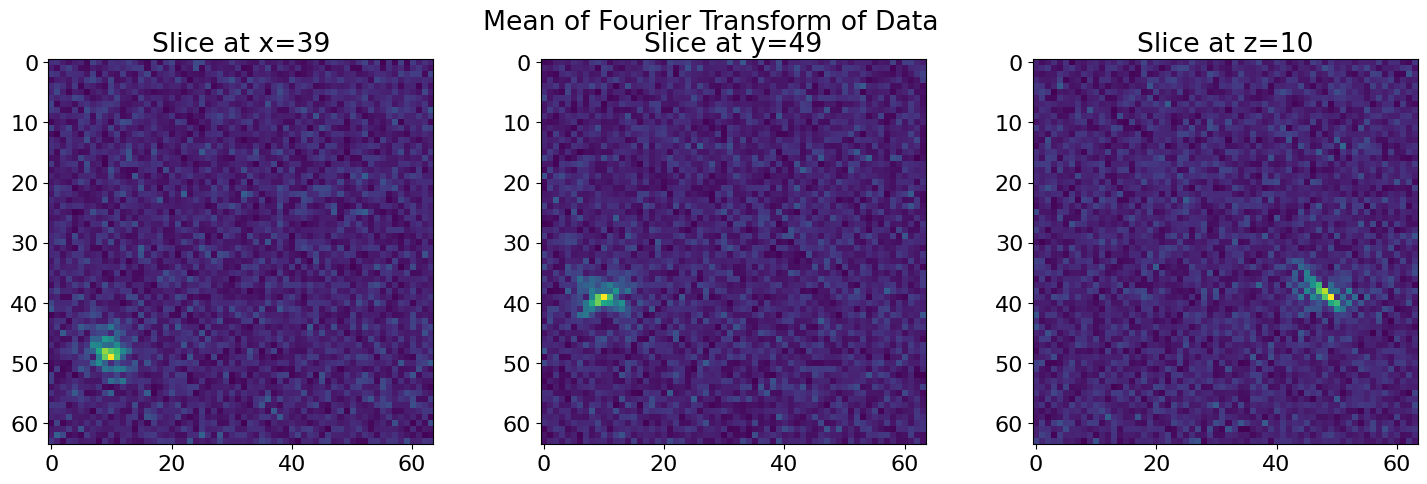

In [6]:
# vmin = np.abs(fhat_shifted_mean_subdata.min())
# vmax = np.abs(fhat_shifted_mean_subdata.max())

fig, ax = plt.subplots(1,3, figsize=(18,5))

ax[0].imshow(np.abs(fhat_shifted_mean_subdata[39,:,:]))
ax[0].set_title('Slice at x=39')

ax[1].imshow(np.abs(fhat_shifted_mean_subdata[:,49,:]))
ax[1].set_title('Slice at y=49')

ax[2].imshow(np.abs(fhat_shifted_mean_subdata[:,:,10]))
ax[2].set_title('Slice at z=10')


plt.suptitle('Mean of Fourier Transform of Data')
plt.savefig('visualizations/visualizing_dominant_frequency.png')
plt.show()

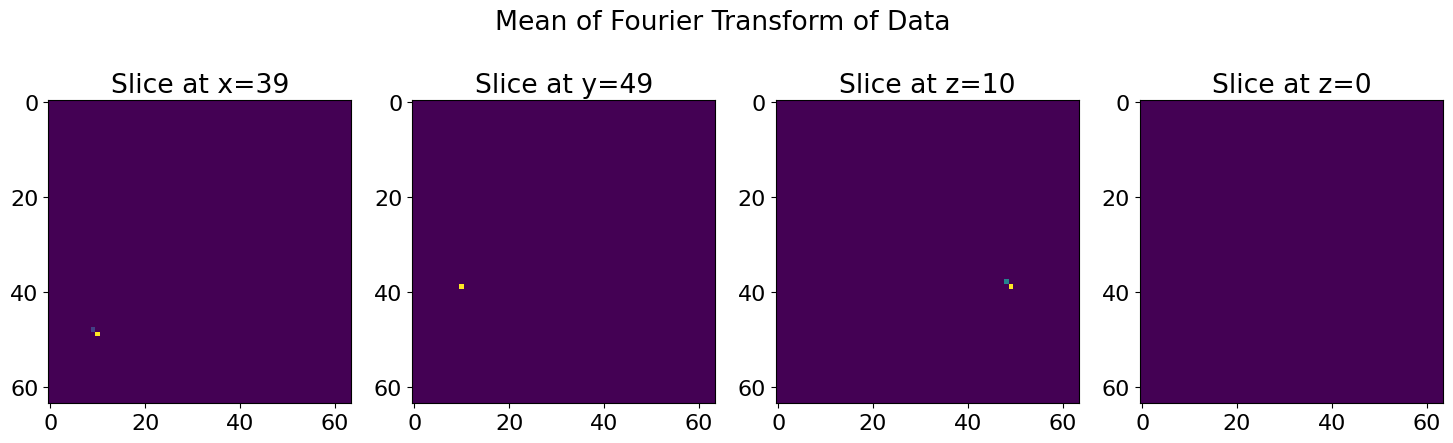

In [7]:
vmin = np.abs(fhat_shifted_mean_subdata.min())
vmax = np.abs(fhat_shifted_mean_subdata.max())

fig, ax = plt.subplots(1,4, figsize=(18,5))

ax[0].imshow(np.abs(fhat_shifted_mean_subdata[39,:,:]), vmin=vmin, vmax=vmax)
ax[0].set_title('Slice at x=39')

ax[1].imshow(np.abs(fhat_shifted_mean_subdata[:,49,:]), vmin=vmin, vmax=vmax)
ax[1].set_title('Slice at y=49')

ax[2].imshow(np.abs(fhat_shifted_mean_subdata[:,:,10]), vmin=vmin, vmax=vmax)
ax[2].set_title('Slice at z=10')

ax[3].imshow(np.abs(fhat_shifted_mean_subdata[:,:,0]), vmin=vmin, vmax=vmax)
ax[3].set_title('Slice at z=0')

plt.suptitle('Mean of Fourier Transform of Data')
plt.savefig('visualizations/visualizing_dominant_frequency_plus.png')
plt.show()

In [8]:
index = np.argmax(fhat_shifted_mean_subdata)
index

fhat_shifted_mean_subdata.flatten()[index]

indices = np.unravel_index([index], (64,64,64))
indices

fhat_shifted_mean_subdata[indices]

kx, ky, kz = np.meshgrid(K_grid, K_grid, K_grid)
kx0, ky0, kz0 = kx[indices], ky[indices], kz[indices]
kx0, ky0, kz0

(array([5.34070751]), array([2.19911486]), array([-6.91150384]))

In [9]:
sigma = 1.3

normalizing_constant = 1
# normalizing_constant = (1 / np.sqrt( 2 * np.pi * sigma**2))

gaussian_filter = normalizing_constant * np.exp( - (1/(2*sigma**2)) * ( (kx - kx0)**2 + (ky - ky0)**2 + (kz - kz0)**2) )
expanded_filter = np.expand_dims(gaussian_filter, axis=3)

fhat_shifted_subdata_filtered = fhat_shifted_subdata * expanded_filter

filtered_signal = np.fft.ifftn(
    np.fft.ifftshift(
        fhat_shifted_subdata_filtered,
        axes=(0, 1, 2)
    ),
    axes=(0,1,2)
)

In [10]:
locations = []

for i in range(49):
    signal_time_slice = filtered_signal[:,:,:,i]

    index = np.argmax(np.abs(signal_time_slice))

    indices = np.unravel_index([index], (64,64,64))
    locations.append(np.array([xv[indices][0], yv[indices][0], zv[indices][0]]))

location_data = np.vstack(locations)

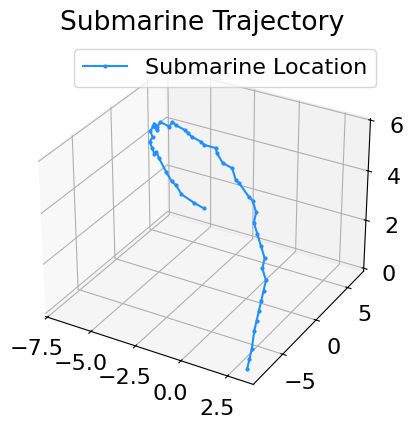

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.set_xlim((-10, 10))
# ax.set_ylim((-10, 10))
# ax.set_zlim((-10, 10))

ax.plot(location_data[:,0], location_data[:,1], location_data[:,2], '-', marker=sub_marker, color='dodgerblue', markersize=marker_size, label="Submarine Location")
plt.title("Submarine Trajectory")
plt.legend()
plt.savefig('visualizations/submarine_static_3d.png')
plt.show()

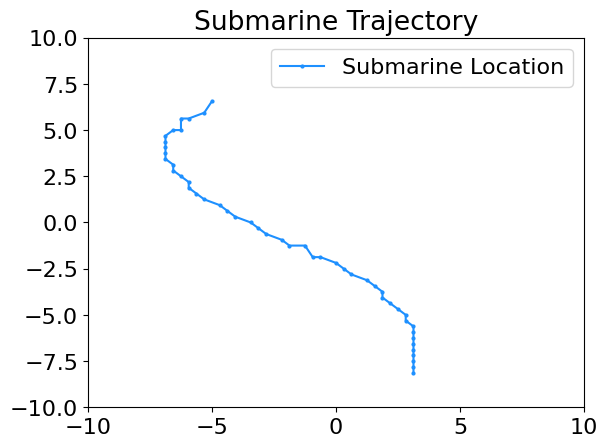

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
# ax.set_zlim((-10, 10))

ax.plot(location_data[:,0], location_data[:,1], '-', marker=sub_marker, color='dodgerblue', markersize=marker_size, label="Submarine Location")
plt.title("Submarine Trajectory")
plt.legend()
plt.savefig('visualizations/submarine_static_2d.png')
plt.show()

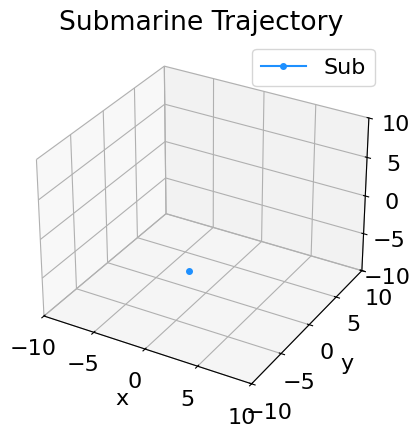

In [13]:
# Set up figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_zlim((-10, 10))

# Initialize the point and trajectory
sub_part, = plt.plot([], [], [], color='dodgerblue', marker=sub_marker, markersize=ani_marker_size, label="Sub")
sub_traj, = plt.plot([], [], [], color='dodgerblue')

# Update function for animation
def update(i):
    # Update the current position
    sub_part.set_data([location_data[i, 0]], [location_data[i, 1]])
    sub_part.set_3d_properties([location_data[i, 2]])
    
    # Update the trajectory
    sub_traj.set_data(location_data[:i+1, 0], location_data[:i+1, 1])
    sub_traj.set_3d_properties(location_data[:i+1, 2])
    
    return sub_part, sub_traj

# Configure animation
ani = animation.FuncAnimation(fig, update, frames=location_data.shape[0], interval=100)

# Optional: Save or display the animation
plt.xlabel("x")
plt.ylabel("y")
plt.title("Submarine Trajectory")
plt.legend()
ani.save("visualizations/submarine_trajectory_3d.gif", writer='pillow')
writer = animation.writers['ffmpeg']
writer = writer(metadata=dict(artist='Hunter Lybbert'), fps=10)
ani.save("visualizations/submarine_trajectory_3d.mp4", writer=writer)
HTML(ani.to_html5_video())


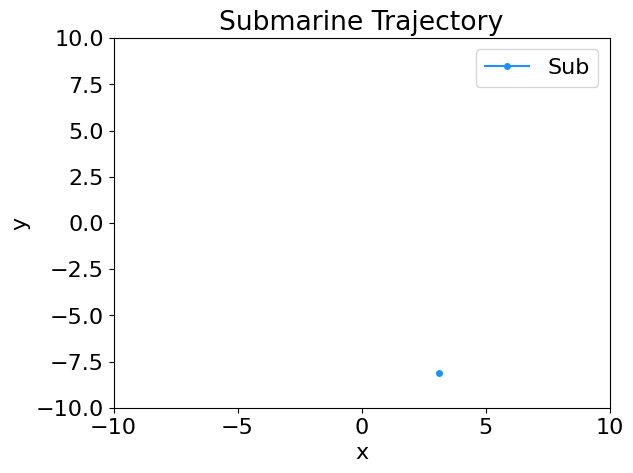

In [14]:
# Set up figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))

# Initialize the point and trajectory
sub_part, = plt.plot([], [], color='dodgerblue', marker=sub_marker, markersize=ani_marker_size, label="Sub")
sub_traj, = plt.plot([], [], color='dodgerblue')

# Update function for animation
def update(i):
    # Update the current position
    sub_part.set_data([location_data[i, 0]], [location_data[i, 1]])
    
    # Update the trajectory
    sub_traj.set_data(location_data[:i+1, 0], location_data[:i+1, 1])
    
    return sub_part, sub_traj

# Configure animation
ani = animation.FuncAnimation(fig, update, frames=location_data.shape[0], interval=100)

# Optional: Save or display the animation
plt.xlabel("x")
plt.ylabel("y")
plt.title("Submarine Trajectory")
plt.legend()
ani.save("visualizations/submarine_trajectory_2d.gif", writer='pillow')
writer = animation.writers['ffmpeg']
writer = writer(metadata=dict(artist='Hunter Lybbert'), fps=10)
ani.save("visualizations/submarine_trajectory_2d.mp4", writer=writer)
HTML(ani.to_html5_video())


Max average frequency the signal across time...
* Apply fft to each time sample independentantly and average the samples
* Averaging gets rid of a little noise
* 

Filtering:
* Filter in the frequency domain like the fft.ipynb notebook

An extra Idea:
* Consider filtering in the signal domain (this one would require the gabor filter)